# Ensembling Machine Learning Methods
The goal of this notebook is to combine the XGBoost predictions with different ML predictors, ensembling the two to (hopefully) create a more robust answer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the test and train data
trainData = pd.read_csv('../data/1e7data_train.csv', index_col=0)
testData = pd.read_csv('../data/1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_min_e2,norm_min_window10_e2,norm_min_e3,norm_min_window10_e3,norm_min_inc1,norm_min_window10_inc1,norm_min_inc2,norm_min_window10_inc2,norm_min_inc3,norm_min_window10_inc3
Sim_ID,,,,,,,,,,,,,,,,,,,,,
4465,True,1.000000e+07,10000000.0,0.000015,0.021544,0.049234,0.010924,0.011821,2.166832,0.011453,...,0.000584,0.025326,0.000058,0.010939,0.000067,0.000212,0.000205,0.001258,0.002236,0.004439
4231,False,5.556366e+05,10000000.0,0.000015,0.021544,0.043888,0.009194,0.004916,-1.426257,0.007699,...,0.000374,0.155129,0.000066,0.002199,0.000106,0.000375,0.000007,0.034136,0.000070,0.000463
487,False,1.955824e+06,10000000.0,0.000015,0.021544,0.056372,0.013384,0.006294,-0.410190,0.003253,...,0.000039,0.023756,0.000583,0.002526,0.000630,0.003254,0.000256,0.000608,0.000759,0.000256
2210,False,4.607903e+03,10000000.0,0.000015,0.021544,0.054535,0.012735,0.007372,-1.748617,0.015612,...,0.000702,0.005107,0.000400,0.006366,0.005785,0.000889,0.000212,0.000663,0.000126,0.000314
4390,True,1.000000e+07,10000000.0,0.000015,0.021544,0.042994,0.008915,0.009054,2.988464,0.013263,...,0.000565,0.008115,0.000088,0.010731,0.000342,0.000861,0.000082,0.001282,0.000835,0.000491


In [191]:
#now load the predicted probability values from XGBoost
data_XGBoost = pd.read_csv("ariSI.csv",header=0)
data_XGBoost.head()

,Sim_ID,daOverRH1,daOverRH2,P2/P1,P3/P2,predprob,predstable,Norbits_instability,Stable
0,1648,6.879240,7.131643,1.230348,1.239099,0.761743,False,1.000000e+07,True
1,3471,8.496936,5.371167,1.286789,1.178497,0.008978,False,8.233677e+05,False
2,3849,6.822671,5.825163,1.228390,1.194028,0.000914,False,7.204145e+03,False
3,3537,5.092680,6.103170,1.169004,1.203572,0.001462,False,5.851915e+03,False
4,4214,8.928228,5.186531,1.301979,1.172200,0.029608,False,6.435885e+06,False


## Which features?
Decide on the features here. On the one hand, you can just try all the features like in XGBoost. Or, you can try just the top features from XGBoost. Or, make your own.

In [214]:
#features = ['avg_a1', 'std_a1', 'max_a1', 'min_a1', 'norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1', 'avg_a2', 'std_a2', 'max_a2', 'min_a2', 'norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'avg_a3', 'std_a3', 'max_a3', 'min_a3', 'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 'avg_e1', 'std_e1', 'max_e1', 'min_e1', 'norm_std_e1', 'norm_max_e1', 'norm_std_window10_e1', 'norm_max_window10_e1', 'avg_e2', 'std_e2', 'max_e2', 'min_e2', 'norm_std_e2', 'norm_max_e2', 'norm_std_window10_e2', 'norm_max_window10_e2', 'avg_e3', 'std_e3', 'max_e3', 'min_e3', 'norm_std_e3', 'norm_max_e3', 'norm_std_window10_e3', 'norm_max_window10_e3', 'daOvera1', 'daOvera2', 'daOverRH1', 'daOverRH2', 'mindaOvera', 'maxdaOvera', 'mindaOverRH', 'maxdaOverRH']
features = ['max_a2','std_a2','mindaOverRH','maxdaOverRH','std_a3','max_e2'] #Top XGB features
y = df['Stable']
X = df[features]

#use XGB probabilities as input
#X["XGB_predprob"] = data_XGBoost["predprob"]
#features.append("XGB_predprob")

X.head()

,max_a2,std_a2,mindaOverRH,maxdaOverRH,std_a3,max_e2
Sim_ID,,,,,,
2414,0.067576,0.000014,6.969123,8.989360,0.000013,0.017359
4056,0.057587,0.000090,5.095487,5.924768,0.000092,0.031996
4855,0.061434,0.000012,7.241825,8.398691,0.000008,0.011019
517,0.067004,0.000010,8.840869,8.943640,0.000009,0.013155
1520,0.054659,0.000068,5.085694,5.908519,0.000066,0.035660


# Support Vector Machine

In [139]:
from sklearn import svm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
#model
model = svm.SVC()
Xnorm = (df[features] - df[features].mean())/df[features].std()  #must normalize for kNN!

#model-specific parameters
gamma = np.logspace(-4,2,5)
C=np.logspace(-1,3,5)
kernel=["rbf"]

#grid search parameters
param_grid = dict(kernel=kernel, gamma=gamma, C=C)
Nfolds = 5

#perform grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='roc_auc',iid=False, cv=Nfolds)
grid.fit(Xnorm,df['Stable'])

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': array([  1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'gamma': array([  1.00000e-04,   3.16228e-03,   1.00000e-01,   3.16228e+00,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [140]:
print "Best params are:",grid.best_params_

Best params are: {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.0031622776601683794}


In [141]:
svcmodel = svm.SVC(kernel="rbf", C=100, gamma=0.003, probability=True)
svcmodel.fit(Xnorm,df['Stable'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.003, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [142]:
Xtestnorm = (dftest[features] - dftest[features].mean())/dftest[features].std()
dtest_predprob = svcmodel.predict_proba(Xtestnorm)[:,1]
dftest["svc_predprob"] = dtest_predprob    #store the predicted values in the dataframe
print "AUC Score (Test): %f" % metrics.roc_auc_score(dftest['Stable'], dtest_predprob)

AUC Score (Test): 0.919814


# KNN Algorithm

In [215]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.neighbors import KNeighborsClassifier
#model + data
model = KNeighborsClassifier(weights="distance")
Xnorm = (df[features] - df[features].mean())/df[features].std()  #must normalize for kNN!

#model-specific parameters
n_neighbors = np.linspace(6,60,10)
metric = ["euclidean","manhattan","minkowski"]

#grid search parameters
param_grid = dict(n_neighbors=n_neighbors, metric=metric)
Nfolds = 5

#perform grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='roc_auc',iid=False, cv=Nfolds)
grid.fit(Xnorm,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_neighbors': array([  6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.]), 'metric': ['euclidean', 'manhattan', 'minkowski']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [216]:
print "Best params are:",grid.best_params_

Best params are: {'n_neighbors': 36.0, 'metric': 'manhattan'}


In [217]:
knnmodel = KNeighborsClassifier(n_neighbors=36, weights='distance',metric="manhattan")
knnmodel.fit(Xnorm,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=36, p=2,
           weights='distance')

In [218]:
Xtestnorm = (dftest[features] - dftest[features].mean())/dftest[features].std()
dtest_predprob = knnmodel.predict_proba(Xtestnorm)[:,1]
dftest["knn_predprob"] = dtest_predprob    #store the predicted values in the dataframe
print "AUC Score (Test): %f" % metrics.roc_auc_score(dftest['Stable'], dtest_predprob)

AUC Score (Test): 0.933490


# RFC

In [219]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150, n_jobs=-1)

#model-specific parameters
max_depth=[None,20,50]
min_samples_split=[5,7,10,15]

#grid search parameters
param_grid = dict(max_depth=max_depth, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
Nfolds = 5

#perform grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='roc_auc',iid=False, cv=Nfolds)
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'min_samples_split': [5, 7, 10, 15], 'max_depth': [None, 20, 50], 'min_samples_leaf': [1, 10, 25]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [220]:
print "Best params are:",grid.best_params_

Best params are: {'min_samples_split': 15, 'max_depth': 50, 'min_samples_leaf': 1}


In [224]:
rfcmodel = RandomForestClassifier(n_estimators=300,max_depth=50,min_samples_split=15,min_samples_leaf=1)
rfcmodel.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

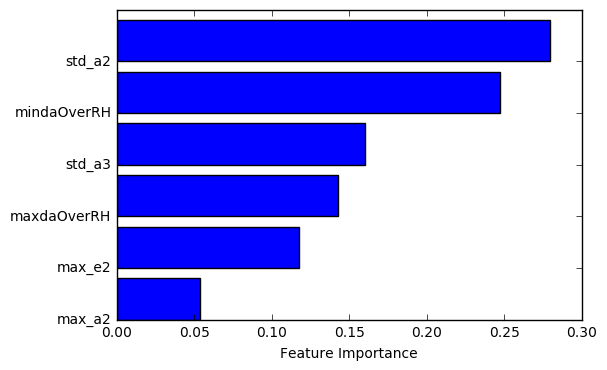

Index([u'max_a2', u'max_e2', u'maxdaOverRH', u'std_a3', u'mindaOverRH',
       u'std_a2'],
      dtype='object')


In [225]:
#feature importances
importances = rfcmodel.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(importances)),importances[indices])
plt.yticks(range(len(importances)),X.columns[indices])
plt.xlabel('Feature Importance')
plt.show()
print X.columns[indices]

In [226]:
dtest_predprob = rfcmodel.predict_proba(dftest[features])[:,1]
dftest["rfc_predprob"] = dtest_predprob    #store the predicted values in the dataframe
print "AUC Score (Test): %f" % metrics.roc_auc_score(dftest['Stable'], dtest_predprob)

AUC Score (Test): 0.943429


# Plot predicted probabilities from trained models above
This is a general purpose plotting function to visualize the predictions. Specify the pred_prob_type from one of the methods analyzed above.

In [229]:
pred_prob_type = "rfc_predprob"   #choices are svc_predprob and knn_predprob right now

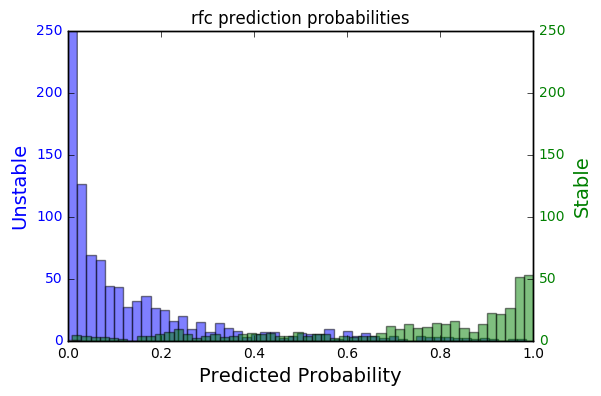

In [230]:
# Histogram:
y_pred=dftest[pred_prob_type]
bins = 50
Stable=y_pred[dftest['Stable'].values]
Unstable=y_pred[~dftest['Stable'].values]

fig, ax1 = plt.subplots()
ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
 
ax1.set_ylim([0,250])
ax2.set_ylim([0,250])
ax1.set_title("%s prediction probabilities"%pred_prob_type.split("_")[0])
plt.savefig("%s.pdf"%pred_prob_type)

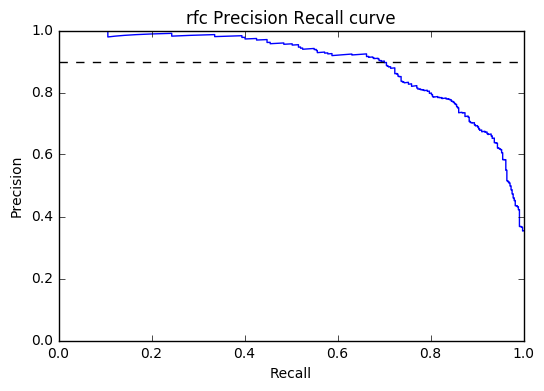

In [231]:
from sklearn.metrics import precision_recall_curve
y_pred=dftest[pred_prob_type]
precision, recall, thresholds = precision_recall_curve(dftest['Stable'], y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.plot([0,1],[0.9,0.9], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('%s Precision Recall curve'%pred_prob_type.split("_")[0])

In [232]:
for i in range(0,len(recall), 40):
    print("Threshold {0}, Precision = {1}, Recall = {2}".format(thresholds[i], precision[i], recall[i]))

Threshold 0.00861536161207, Precision = 0.353784860558, Recall = 1.0
Threshold 0.0118524294333, Precision = 0.364609053498, Recall = 0.997747747748
Threshold 0.0152455535135, Precision = 0.374468085106, Recall = 0.990990990991
Threshold 0.019987968659, Precision = 0.387665198238, Recall = 0.990990990991
Threshold 0.0247759619513, Precision = 0.401826484018, Recall = 0.990990990991
Threshold 0.0312031787585, Precision = 0.417061611374, Recall = 0.990990990991
Threshold 0.0385560284659, Precision = 0.431527093596, Recall = 0.986486486486
Threshold 0.0478947195829, Precision = 0.447179487179, Recall = 0.981981981982
Threshold 0.0602441196512, Precision = 0.464171122995, Recall = 0.977477477477
Threshold 0.071464997965, Precision = 0.483798882682, Recall = 0.975225225225
Threshold 0.08446473969, Precision = 0.504093567251, Recall = 0.970720720721
Threshold 0.101284142762, Precision = 0.525153374233, Recall = 0.963963963964
Threshold 0.120939131087, Precision = 0.550967741935, Recall = 0.96

[]

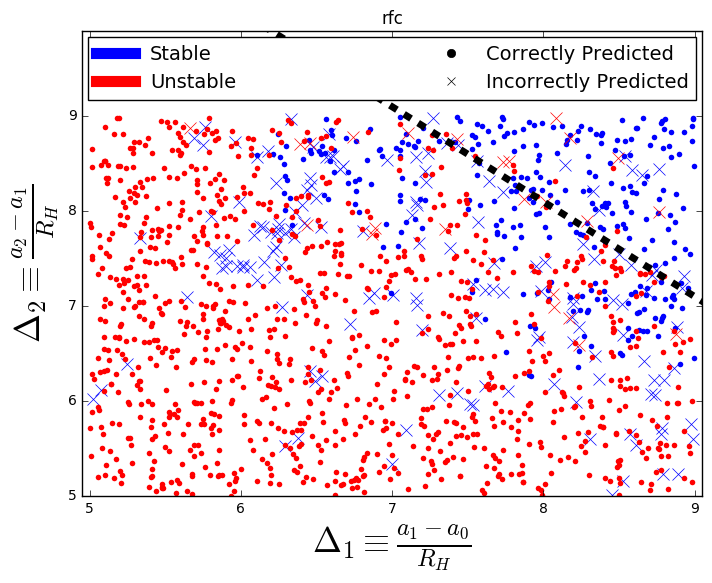

In [233]:
Stable_Thresh = 0.7    #Need the appropriate stable/unstable threshold for the corresponding pred_prob_type

Stable = dftest[dftest["Stable"]==True]
Unstable = dftest[dftest["Stable"]==False]
xaxis = "daOverRH1"
yaxis = "daOverRH2"
fontsize=25
tickfontsize=16

fig, axes = plt.subplots(figsize=(8,6))
stable_pred_color="Blue"
unstable_pred_color="Red"
axes.plot(Stable[xaxis].loc[Stable[pred_prob_type]>Stable_Thresh],Stable[yaxis].loc[Stable[pred_prob_type]>Stable_Thresh],marker="o",markersize=4,mew=0,color=stable_pred_color,linestyle="None",label="Stable, Predicted Stable")
axes.plot(Stable[xaxis].loc[Stable[pred_prob_type]<=Stable_Thresh],Stable[yaxis].loc[Stable[pred_prob_type]<=Stable_Thresh],marker="x",markersize=8,color=stable_pred_color,linestyle="None",label="Stable, Predicted Unstable")
axes.plot(Unstable[xaxis].loc[Unstable[pred_prob_type]>Stable_Thresh],Unstable[yaxis].loc[Unstable[pred_prob_type]>Stable_Thresh],marker="x",markersize=8,color=unstable_pred_color,linestyle="None",label="Unstable, Predicted Stable")
axes.plot(Unstable[xaxis].loc[Unstable[pred_prob_type]<=Stable_Thresh],Unstable[yaxis].loc[Unstable[pred_prob_type]<=Stable_Thresh],marker="o",markersize=4,mew=0,color=unstable_pred_color,linestyle="None",label="Unstable, Predicted Unstable")
miny,maxy,minx,maxx = 5,9.9,4.95,9.05
axes.set_ylim([miny,maxy])
axes.set_xlim([minx,maxx])
axes.set_xlabel(r"$ \Delta_1 \equiv \frac{a_1 - a_0}{R_H}$", fontsize=fontsize)
axes.set_ylabel(r"$ \Delta_2 \equiv \frac{a_2 - a_1}{R_H}$", fontsize=fontsize) 
#leg = axes.legend(loc="upper left",numpoints=1,fontsize=8,scatterpoints=1)

blue = plt.Line2D((0,1),(0,0), color='b', linestyle='-', linewidth=8)
red = plt.Line2D((0,1),(0,0), color='r', linestyle='-', linewidth=8)
correct = plt.Line2D(range(1), range(1), color="black", marker='o', markerfacecolor="black", linestyle='')
incorrect = plt.Line2D(range(1), range(1), color="black", marker='x', markerfacecolor="black", linestyle='')
leg = axes.legend([blue, red, correct, incorrect], ['Stable', 'Unstable', 'Correctly Predicted', 'Incorrectly Predicted'], ncol=2, numpoints=1, fontsize=14, mode="expand", borderaxespad=0.3,loc='upper right')

#Lissauer et al. (2011)
RHThresh = 16.1
x = np.arange(5,10,0.1)
axes.plot(x,RHThresh-x, 'k--', lw=5, label='$\Delta_1 + \Delta_2$=%.1f'%RHThresh)

axes.set_title(pred_prob_type.split("_")[0])
axes.plot()


# Ensembling
Here is where the actual ensembling takes place. Everything above is looking at different machine learning methods, trying to train them.

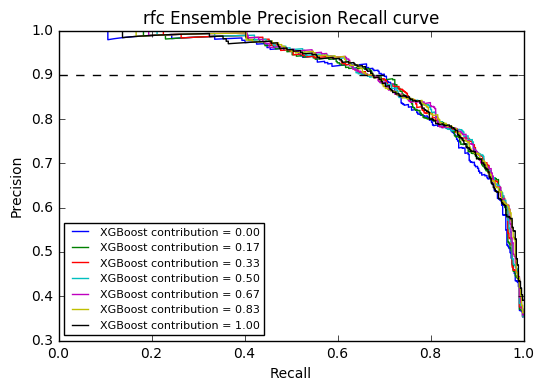

In [236]:
pred_prob_type = "rfc_predprob"   #choices are svc_predprob and knn_predprob right now

XGBoost_frac = np.linspace(0,1,7)
y_pred_XGB = data_XGBoost["predprob"]
y_pred_2 = dftest[pred_prob_type]
fig, ax = plt.subplots()

for f in XGBoost_frac:
    y_pred_avg = f*np.asarray(y_pred_XGB) + (1.-f)*np.asarray(y_pred_2)
    precision, recall, thresholds = precision_recall_curve(dftest['Stable'], y_pred_avg)
    ax.plot(recall, precision, label='XGBoost contribution = %.2f'%f)

ax.plot([0,1], [0.9,0.9],'k--')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left',fontsize=8)
ax.set_title('%s Ensemble Precision Recall curve'%pred_prob_type.split("_")[0])
plt.savefig("PR-%s_Ensemble.pdf"%pred_prob_type.split("_")[0])